In [1]:
from google.cloud import bigquery, storage
import os
import pandas as pd

In [2]:
bigquery_client = bigquery.Client.from_service_account_json("../../config/neuraltwin-545b2b43070a.json")
storage_client = storage.Client.from_service_account_json("../../config/neuraltwin-545b2b43070a.json")

# Generate bigquery tables for measurements, failures, and metadata from raw data in GCS

In [38]:
def load_folder_into_bigquery(folder_url: str, table_id: str, bigquery_client: bigquery.Client, storage_client: storage.Client):
    """
    Loads all files from a given folder in Google Cloud Storage into a BigQuery table.
    Auto-detects:
        - File format (CSV, NDJSON, Parquet) from a single file in the folder.
        - Schema from the file contents.
    Overwrites the table if it already exists.
    After ingestion:
        - If a column named 'timestamp' exists and is inferred as DATE,
          automatically converts it into TIMESTAMP.
    Assumes all files in the folder are of the same format.
    """

    # Normalize folder path (ensure trailing slash)
    if not folder_url.endswith("/"):
        folder_url += "/"

    # Extract bucket name & prefix from folder URL
    if not folder_url.startswith("gs://"):
        raise ValueError("folder_url must start with 'gs://'")
    bucket_name = folder_url.split("/")[2]
    prefix = "/".join(folder_url.split("/")[3:])

    # Use GCS client to find one file in the folder
    blobs = list(storage_client.list_blobs(bucket_name, prefix=prefix, max_results=1))

    if not blobs:
        raise FileNotFoundError(f"No files found in {folder_url}")

    # Get the first file's extension to determine source format
    first_file = blobs[0].name
    extension = os.path.splitext(first_file)[1].lower()

    # Map file extension to BigQuery source format
    if extension == ".csv":
        source_format = bigquery.SourceFormat.CSV
    elif extension in (".json", ".ndjson"):
        source_format = bigquery.SourceFormat.NEWLINE_DELIMITED_JSON
    elif extension == ".parquet":
        source_format = bigquery.SourceFormat.PARQUET
    else:
        raise ValueError(f"Unsupported file format '{extension}' in {first_file}")

    # Configure the load job
    job_config = bigquery.LoadJobConfig(
        autodetect=True,
        write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE,
        source_format=source_format
    )

    # Start the load job for all files in the folder
    load_job = bigquery_client.load_table_from_uri(
        f"{folder_url}*",
        table_id,
        job_config=job_config,
    )

    # Wait for completion and handle errors
    try:
        load_job.result()
    except Exception as e:
        print(f"❌ BigQuery load failed: {e}")
        if load_job.errors:
            print("BigQuery job errors:", load_job.errors)
        raise

    # Check if 'timestamp' column exists and its type
    table = bigquery_client.get_table(table_id)
    timestamp_field = next((f for f in table.schema if f.name.lower() == "timestamp"), None)

    if timestamp_field:
        if timestamp_field.field_type.upper() == "DATE":
            print(f"ℹ️ Column 'timestamp' detected as DATE. Converting to TIMESTAMP...")

            query = f"""
            CREATE OR REPLACE TABLE `{table_id}` AS
            SELECT
                CAST(timestamp AS TIMESTAMP) AS timestamp,
                *
            EXCEPT(timestamp)
            FROM `{table_id}`
            """

            bigquery_client.query(query).result()
            print(f"✅ Converted 'timestamp' column from DATE to TIMESTAMP in {table_id}.")
        else:
            print(f"✅ Column 'timestamp' already has type {timestamp_field.field_type}. No conversion needed.")
    else:
        print(f"ℹ️ No 'timestamp' column found in {table_id}.")

    # Fetch the table and report
    destination_table = bigquery_client.get_table(table_id)
    print(f"✅ Loaded {destination_table.num_rows} rows into {table_id} ({source_format}).")

In [ ]:
for data_type in ["measurements", "failures", "metadata"]:
    load_folder_into_bigquery(
        folder_url=f"gs://neuraltwin/data/wagon_data/{data_type}/",
        table_id=f"neuraltwin.wagon_data.{data_type}",
        bigquery_client=bigquery_client,
        storage_client=storage_client
    )

✅ Column 'timestamp' already has type TIMESTAMP. No conversion needed.
✅ Loaded 109973 rows into neuraltwin.wagon_data.measurements (PARQUET).


# Train classification model

In [3]:
# load measurements table
measurements = pd.read_gbq("SELECT * FROM `neuraltwin.wagon_data.measurements`", project_id="neuraltwin", dialect="standard")

In [5]:
failures = pd.read_gbq("SELECT id, timestamp FROM `neuraltwin.wagon_data.failures`", project_id="neuraltwin", dialect="standard")

In [8]:
training_data = measurements
training_data["failure"] = 0.0
# in training data, set the failure flag to 1.0 for rows where id and timestamp match failures table
for _, row in failures.iterrows():
    training_data.loc[
        (training_data["id"] == row["id"]) & (training_data["timestamp"] == row["timestamp"]),
        "failure"
    ] = 1.0
training_data.drop(columns=["id", "timestamp"], inplace=True)

,Description,Value
0,Session id,3845
1,Target,failure
2,Target type,Binary
3,Original data shape,"(109973, 6)"
4,Transformed data shape,"(109973, 6)"
5,Transformed train set shape,"(76981, 6)"
6,Transformed test set shape,"(32992, 6)"
7,Numeric features,5
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.9963,0.9982,1.0000,0.5017,0.6672,0.6656,0.7064,0.0370
qda,Quadratic Discriminant Analysis,0.0036,0.0000,1.0000,0.0036,0.0072,0.0000,0.0000,0.0660
lda,Linear Discriminant Analysis,0.9965,0.9982,0.9893,0.5128,0.6744,0.6728,0.7104,0.0470
gbc,Gradient Boosting Classifier,0.9966,0.8933,0.8786,0.5388,0.6519,0.6503,0.6782,4.6870
rf,Random Forest Classifier,0.9964,0.9981,0.4944,0.5113,0.4963,0.4945,0.4978,0.9470
ada,Ada Boost Classifier,0.9965,0.9925,0.4876,0.5324,0.5039,0.5021,0.5052,1.4060
lr,Logistic Regression,0.9963,0.9982,0.4734,0.4948,0.4738,0.4719,0.4770,1.0950
knn,K Neighbors Classifier,0.9960,0.9873,0.4733,0.4514,0.4577,0.4557,0.4580,0.2980
et,Extra Trees Classifier,0.9960,0.9980,0.4550,0.4545,0.4521,0.4501,0.4514,0.3970
dt,Decision Tree Classifier,0.9961,0.7249,0.4517,0.4698,0.4573,0.4553,0.4571,0.0580


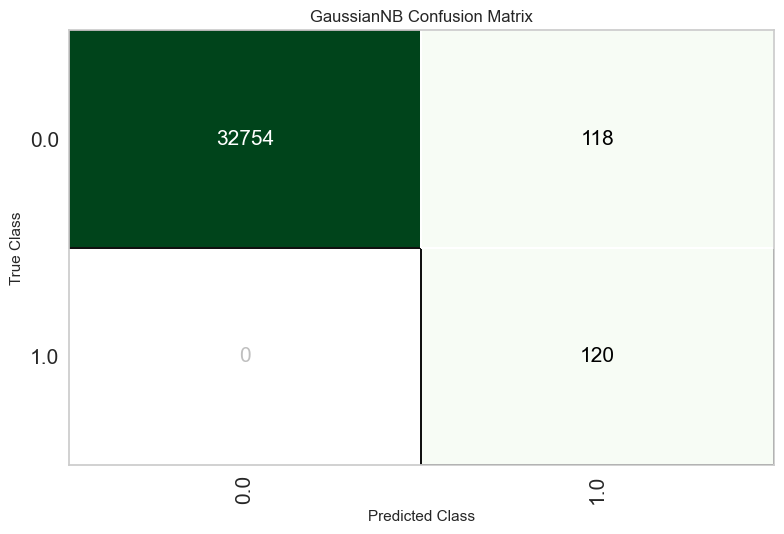

In [10]:
from pycaret.classification import setup, compare_models, plot_model

clf = setup(data=training_data, target="failure")

best = compare_models(sort="Recall")  # Sort models by recall
plot_model(best, plot="confusion_matrix")

In [13]:
# use bigquery's AI.FORECAST to predict all values of all columns in neuraltwin.wagon_data.measurements for each id for the next 7 days

sql = """
SELECT
  *
FROM
  AI.FORECAST(
    TABLE `neuraltwin.wagon_data.measurements`,
    data_col => 'speed',
    timestamp_col => 'timestamp',
    model => 'TimesFM 2.0',
    id_cols => ['id'],
    horizon => 7,
    confidence_level => .75
  )"""
forecast = pd.read_gbq(sql, project_id="neuraltwin", dialect="standard")

In [14]:
forecast

,id,forecast_timestamp,forecast_value,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,ai_forecast_status
0,WGN-12677,2025-08-03 00:00:00+00:00,46.364788,0.75,45.745844,46.983732,
1,WGN-12677,2025-08-04 00:00:00+00:00,46.552032,0.75,45.929411,47.174654,
2,WGN-12677,2025-08-05 00:00:00+00:00,46.368530,0.75,45.772384,46.964676,
3,WGN-12677,2025-08-06 00:00:00+00:00,46.469608,0.75,45.843755,47.095462,
4,WGN-12677,2025-08-07 00:00:00+00:00,46.373707,0.75,45.771257,46.976157,
...,...,...,...,...,...,...,...
695,WGN-57348,2025-08-05 00:00:00+00:00,35.454525,0.75,34.838978,36.070072,
696,WGN-57348,2025-08-06 00:00:00+00:00,35.483704,0.75,34.847632,36.119775,
697,WGN-57348,2025-08-07 00:00:00+00:00,35.361713,0.75,34.735377,35.988050,
698,WGN-57348,2025-08-08 00:00:00+00:00,35.355129,0.75,34.714031,35.996227,


In [11]:
measurements

,speed,brake,temp,vibration,battery,failure
0,54.002944,7.306192,45.830154,3.197587,76.830889,0.0
1,54.232759,7.408736,46.195082,3.332509,75.327108,0.0
2,54.746500,7.729268,46.868094,3.434027,74.511594,0.0
3,50.936008,8.476860,42.295860,4.768649,63.807434,0.0
4,56.493634,7.297759,47.067752,2.832947,83.067205,0.0
...,...,...,...,...,...,...
109968,53.095428,5.894801,41.857358,3.293300,73.749331,0.0
109969,51.495561,6.283052,41.905724,4.598188,67.174065,0.0
109970,46.711807,7.895089,46.945902,5.566582,54.885413,0.0
109971,45.217378,7.736500,46.591751,5.732312,53.715836,0.0
